**This project is a part of a competition on Kaggle. In this project we will work with a time-series dataset consisting of daily sales data splitted by shop and item ids. The data was provided by one of the largest Russian software firms - 1C Company.<br>The challenge is the following: the company asks us to predict total sales for every product and store in the next month.**<br>
Link to competition: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

## Table of contents
1) Project description<br>
2) Choice of a metric<br>
3) Merging data and EDA<br>
4) Cross-validation strategy<br>
5) Simple baselines<br>
6) Data preprocessing<br>
7) Future engineering<br>
8) Selection of algorithms suitable for the task and their evaluation<br> 
9) Hyperparameter optimization<br>
10) Choosing a final model<br>
11) Further ways to improve models<br>
12) Conclusions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import product
import numpy as np

%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
sns.set()
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (10, 7), 'axes.titlesize': 18})

import warnings
warnings.filterwarnings('ignore')

### File descriptions
(link to data: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)<br>
   **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.<br>
   **test.csv** - the test set. Our goal is to **predict monthly (for November 2015) sales for every shop_id and item_id, which must be in the range [0,20]**.<br>
   **items.csv** - supplemental information about the items/products.<br>
   **item_categories.csv**  - supplemental information about the items categories.<br>
   **shops.csv**- supplemental information about the shops.

In [2]:
train_df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
shops_df = pd.read_csv('shops.csv')
items_df = pd.read_csv('items.csv')
categories_df = pd.read_csv('item_categories.csv')

### Data fields:<br>
1) **shop_id** - unique identifier of a shop<br>
2) **item_id** - unique identifier of a product<br>
3) **item_category_id** - unique identifier of item category<br>
4) **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure<br>
5) **item_price** - current price of an item<br>
6) **date** - date in format dd/mm/yyyy<br>
7) **date_block_num** - a month number, i.e. January 2013 is 0, February 2013 is 1,..., October 2015 is 33<br>
8) **item_name** (items_df) - name of item<br>
9) **shop_name** (shop_df) - name of shop<br>
10) **item_category_name** (categories_df) - name of item category<br>
11) **ID** (test_df) - an Id that represents a (Shop, Item) tuple within the test set

### Choice of a metric (will be replaced)
As the customer has the following requirements:

- Better to make an **over-forecast** than an under-forecast. <br><br>Root mean squared log error (**RMSLE**) incurs a larger penalty for the underestimation of the Actual variable than the Overestimation (which will be good in our case, because predicted values are to be in range [0,20] and in future monthly train data we have small sales count like range [0,7], so we're going to have underestimation of true values and to make model more robust, we should penalize it for underestimation), while Root mean squared error (**RMSE**) or **MAE** treat under- and overestimation equally<br>Lack - RMSLE has bad interpretation<br>
- **Understandable** metric for business <br><br>MAE (simple, good interpretability), MAPE (but can be infinite/underfined with 0 true values, which can appear in data) or Mean absolute scaled error with one-step seasonal naive forecast method in denominator would be great

So in a nutshell we have to make trained model more robust - it's better to use **RMSLE**, but to make model results be interpretable - it's better to use **MAE** or **MASE**.<br>Here I'll stop on RMSLE

In [19]:
from sklearn.metrics import mean_squared_log_error

def root_mean_sqr_log_error(y_tr, y_pr):
    return np.sqrt(mean_squared_log_error(y_tr, y_pr))

## Merging data

In the beginning we'll explore and merge data that we have, i.e. compare test and train data, add info from datasets about items and shops. Then for a joint data we'll make EDA. After EDA there will be a need to convert data from daily sales to monthly sales.

In [9]:
# some general info
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [195]:
train_df['date'] = pd.to_datetime(train_df.date, dayfirst=True)
train_df.sort_values(by='date', inplace=True)
train_df.index = pd.Index(range(train_df.shape[0]))

The shape of train dataframe is 6 columns and 2,935,849 observations.

In [196]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [12]:
# no nan values
train_df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

**Compare train and test data**. Leave only shop and items ids which are present only in test data.

In [197]:
test_df.shape # 3 columns and 214,200 observations

(214200, 3)

**All shops in test data are present in train data, but there are 18 extra shops in train data**. After doing the same thing for item ids, we'll exclude those shop and item ids which are absent from test data.

In [198]:
# how many shops absent from train data which are in test data
len(set(test_df.shop_id.unique()) - set(train_df.shop_id.unique()))

0

In [199]:
# also I've checked particularly shops for the year of 2015 (started from date_block 24)
len(set(test_df.shop_id.unique()) - set(train_df[train_df.date_block_num > 23].shop_id.unique()))

0

In [200]:
# how many shops absent from test data which are in train data
len(set(train_df.shop_id.unique()) - set(test_df.shop_id.unique()))

18

### Shops dataframe
We can see that **most shop names contain the city name on the 1st place**.<br>We have here some similar shop names like "!Якутск Орджоникидзе, 56 фран" (shop_id=0) and "Якутск Орджоникидзе, 56" (shop_id=57). We should decide whether these are the same shops or different (this must be done both for train and test data). If they're the same, then we replace one by another (the one present in test data), if not, then one of two of them will be excluded.In order to understand this, let's merge **shop_df** with **train_df**.

In [203]:
shops_df

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [201]:
train_df = pd.merge(train_df, shops_df, on='shop_id')
train_df.isna().sum() # no nans, merging was succesfull

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
shop_name         0
dtype: int64

We are concerned about pairs of shop id (0 and 57), (1 and 58) and (10 and 11)

In [80]:
test_df.shop_id.unique()
# test data has no shops with id 11, 0, 1

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

**Shops with id 10 and 11 (not present in test data), where names are different by the last element: Жуковский ул. Чкалова 39м? vs. Жуковский ул. Чкалова 39м²**

**Shop 10** was firstly mentioned on 02/01/2013, the last mention is on the last day of train data - 31st October 2015. It also has no sales in February 2015, while **shop 11** has.

In [202]:
train_df[(train_df.shop_id==10)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2467889,2013-01-02,0,10,7218,1308.0,1.0,Жуковский ул. Чкалова 39м?
2467890,2013-01-02,0,10,3686,734.0,1.0,Жуковский ул. Чкалова 39м?
2467891,2013-01-02,0,10,13736,483.0,1.0,Жуковский ул. Чкалова 39м?
2467892,2013-01-02,0,10,5034,1673.0,1.0,Жуковский ул. Чкалова 39м?
2467893,2013-01-02,0,10,3869,1995.0,1.0,Жуковский ул. Чкалова 39м?


In [203]:
train_df[(train_df.shop_id==10)].date.max()

Timestamp('2015-10-31 00:00:00')

**Shop 11** was firstly mentioned on 01/02/2015 and has sales only in February 2015.

In [204]:
train_df[(train_df.shop_id==11)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2935044,2015-02-01,25,11,4181,866.0,2.0,Жуковский ул. Чкалова 39м²
2935045,2015-02-01,25,11,2424,2079.0,1.0,Жуковский ул. Чкалова 39м²
2935046,2015-02-01,25,11,4334,588.0,1.0,Жуковский ул. Чкалова 39м²
2935047,2015-02-01,25,11,3364,942.0,1.0,Жуковский ул. Чкалова 39м²
2935048,2015-02-01,25,11,3934,2866.0,1.0,Жуковский ул. Чкалова 39м²


In [88]:
# sales of shop 11 only in February 2015
train_df[(train_df.shop_id==11)].date.max()

Timestamp('2015-02-28 00:00:00')

In [87]:
# shop 10 has no sales in February 2015 while shop 11 has
train_df[(train_df.shop_id==10) & (train_df.date >= pd.to_datetime('2015-02-01')) & ((train_df.date <= pd.to_datetime('2015-02-28')))].date

Series([], Name: date, dtype: datetime64[ns])

In [205]:
# most popular items in shop 10
train_df[(train_df.shop_id==10)].item_id.value_counts().head()

20949    513
4181     213
5822     124
7856     122
4178     102
Name: item_id, dtype: int64

In [206]:
# most popular items in shop 11
train_df[(train_df.shop_id==11)].item_id.value_counts().head()

20949    17
4181     11
16825     6
7087      6
22162     5
Name: item_id, dtype: int64

I think that we can replace shop 11 (not present in test data!) with shop 10, they have no intersection in sales dates, particularly shop 11 had sales only on February 2015, while shop 10 had sales the whole year in 2015 except February, so probably there's a mistake in their names, first two out of 5 most popular item ids are identical, so there will be no shop 11 in train data but shop 10 after removing shop ids which are not present test data.

**Shops with id 0 (not present in test data) and 57, where names are different by the first element and last word: !Якутск Орджоникидзе, 56 фран vs. Якутск Орджоникидзе, 56**

**Shop 0** was firstly mentioned on 03/01/2013, the last mention is on the last day of February 2013. Sales in this shop were made only in January-Fabruary 2013

In [207]:
train_df[(train_df.shop_id==0)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2534246,2013-01-03,0,0,17560,247.0,1.0,"!Якутск Орджоникидзе, 56 фран"
2534247,2013-01-03,0,0,18283,110.0,1.0,"!Якутск Орджоникидзе, 56 фран"
2534248,2013-01-03,0,0,18281,110.0,1.0,"!Якутск Орджоникидзе, 56 фран"
2534249,2013-01-03,0,0,17762,70.0,1.0,"!Якутск Орджоникидзе, 56 фран"
2534250,2013-01-03,0,0,17914,1159.0,1.0,"!Якутск Орджоникидзе, 56 фран"


In [94]:
train_df[(train_df.shop_id==0)].date.max()

Timestamp('2013-02-28 00:00:00')

**Shop 57** has sales from March 2013 till the last date in train data - 31st October 2015. 

In [208]:
train_df[(train_df.shop_id==57)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2616976,2013-03-01,2,57,484,300.0,2.0,"Якутск Орджоникидзе, 56"
2616977,2013-03-01,2,57,258,249.0,1.0,"Якутск Орджоникидзе, 56"
2616978,2013-03-01,2,57,257,249.0,1.0,"Якутск Орджоникидзе, 56"
2616979,2013-03-01,2,57,111,199.0,1.0,"Якутск Орджоникидзе, 56"
2616980,2013-03-01,2,57,97,149.0,1.0,"Якутск Орджоникидзе, 56"


In [96]:
train_df[(train_df.shop_id==57)].date.max()

Timestamp('2015-10-31 00:00:00')

In [109]:
train_df[(train_df.shop_id==0)].item_id.value_counts().head()

12134    38
13071    35
4163     32
4164     30
14433    29
Name: item_id, dtype: int64

In [110]:
train_df[(train_df.shop_id==57)].item_id.value_counts().head()

20949    759
4178     379
4181     339
4870     314
12134    278
Name: item_id, dtype: int64

So both shops have no intersection in sales dates, one of them was sold during 2 first months of train data, while the other during next months and lastly mentioned in the end of the train data. I was also surfing on the Internet, trying to find some info what means "фран", there's a furniture company Fran in Russia, on oficial web-site there's no shop in Yakutsk, maybe it was really furniture shop which was then relocated, but we don't have items for this shop which can be connacted somehow with furniture. Unfortunately, their most popular items differ, so I won't consider them to be the same shop

**Shops with id 1 (not present in test data) and 58, where names are different by the first element and last word: !Якутск  ТЦ "Центральный" фран vs. Якутск  ТЦ "Центральный"**

**Shop 1** has sales in January-Fabruary 2013 the same as for shop 0. 

In [209]:
train_df[(train_df.shop_id==1)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2528568,2013-01-03,0,1,2808,735.0,1.0,"!Якутск ТЦ ""Центральный"" фран"
2528569,2013-01-03,0,1,1871,177.0,1.0,"!Якутск ТЦ ""Центральный"" фран"
2528570,2013-01-03,0,1,2055,236.0,1.0,"!Якутск ТЦ ""Центральный"" фран"
2528571,2013-01-03,0,1,2302,1088.0,1.0,"!Якутск ТЦ ""Центральный"" фран"
2528572,2013-01-03,0,1,1933,1328.0,1.0,"!Якутск ТЦ ""Центральный"" фран"


In [102]:
train_df[(train_df.shop_id==1)].date.max()

Timestamp('2013-02-28 00:00:00')

**Shop 58** has sales from March 2013 till the last date in train data - 31st October 2015.

In [210]:
train_df[(train_df.shop_id==58)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
2734404,2013-03-01,2,58,19232,399.0,1.0,"Якутск ТЦ ""Центральный"""
2734405,2013-03-01,2,58,21524,199.0,1.0,"Якутск ТЦ ""Центральный"""
2734406,2013-03-01,2,58,19929,419.3,1.0,"Якутск ТЦ ""Центральный"""
2734407,2013-03-01,2,58,19811,349.0,2.0,"Якутск ТЦ ""Центральный"""
2734408,2013-03-01,2,58,19860,149.0,1.0,"Якутск ТЦ ""Центральный"""


In [104]:
train_df[(train_df.shop_id==58)].date.max()

Timestamp('2015-10-31 00:00:00')

The same situation as with the previous pair of shops.Their most popular items differ, so I won't consider them to be the same shop

**As shops 0, 1 and 11 aren't present in test data, the first two will be deleted (when we leave only shops and items which are present in test data) and shop 11 will be replaced by shop 10**

In [211]:
# Жуковский ул. Чкалова 39м?
train_df.loc[train_df.shop_id == 11, 'shop_id'] = 10
train_df.loc[train_df.shop_name == 'Жуковский ул. Чкалова 39м²', 'shop_name'] = 'Жуковский ул. Чкалова 39м?'

**363 items are present in test data and absent from train data. Looking at total test data, 7% of test data contains observations with missing item ids from train data. Predictions for missing item ids from train data will be based on predictions for other items which belong to the same shop (as we have no missing shop ids in train data)**

In [212]:
# how many items absent from train data which are in test data
len(set(test_df.item_id.unique()) - set(train_df.item_id.unique()))

363

In [213]:
# shape of test data with absent item ids in test df from train df
test_df[test_df.item_id.isin(list(set(test_df.item_id.unique()) - set(train_df.item_id.unique())))].shape[0]

15246

In [117]:
15246 / test_df.shape[0] 
# about 7% of test data 

0.0711764705882353

In [118]:
# how many items absent from test data which are in train data
# we'll remove these item ids
len(set(train_df.item_id.unique()) - set(test_df.item_id.unique()))

17070

In [214]:
test_shop_ids = test_df['shop_id'].unique()
test_item_ids = test_df['item_id'].unique()
train_df = train_df[train_df['shop_id'].isin(test_shop_ids)]
train_df = train_df[train_df['item_id'].isin(test_item_ids)]

In **items_df** we have unique item_id, corresponding category id with which this dataframe connected to **categories_df**, and name of the item. In **categories_df** we have unique category id and corresponding name of the category. 

In [215]:
items_df.shape # 3 columns and 22,170 observations

(22170, 3)

In [163]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


84 unique categories

In [123]:
items_df.item_category_id.nunique()

84

In [164]:
# both tables are connected through item_category_id, for convenience join them
categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [216]:
items_cats_df = pd.merge(items_df, categories_df, on='item_category_id')
# no missing values
items_cats_df.isna().sum()

item_name             0
item_id               0
item_category_id      0
item_category_name    0
dtype: int64

In [217]:
train_df = pd.merge(train_df, items_cats_df, on='item_id')
# no missing values
train_df.isna().sum() 

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

The previous shape of train data was almost 3 billion, which is more than 2 times then current shape

In [218]:
train_df.shape

(1224837, 10)

## EDA

Explore numerical variables like **item_price** and **item_cnt_day** on daily basis. Both variables have **right-skewed distribution**, as their median < mean

In [219]:
train_df.loc[:,['item_price', 'item_cnt_day']].describe().round(2)
# in item count all quartiles equal to 1 and there are negative values

,item_price,item_cnt_day
count,1224837.00,1224837.00
mean,1030.67,1.32
std,1827.62,3.31
min,0.50,-16.00
25%,299.00,1.00
50%,549.00,1.00
75%,1199.00,1.00
max,59200.00,2169.00


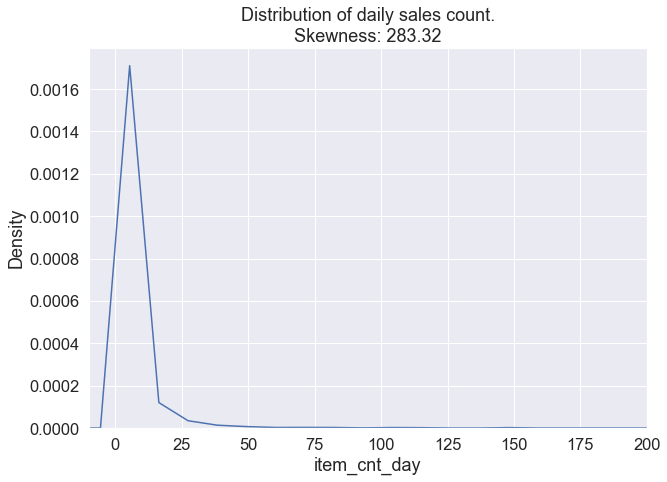

In [128]:
ax = sns.kdeplot(x=train_df.item_cnt_day)
ax.set_title('Distribution of daily sales count.\nSkewness: {}'.format(str(round(stats.skew(train_df.item_cnt_day), 2))))
ax.set_xlim(-10,200);

In [129]:
train_df.item_cnt_day.quantile(0.99)
# less than 1% of observations have item_cnt_day > 7

7.0

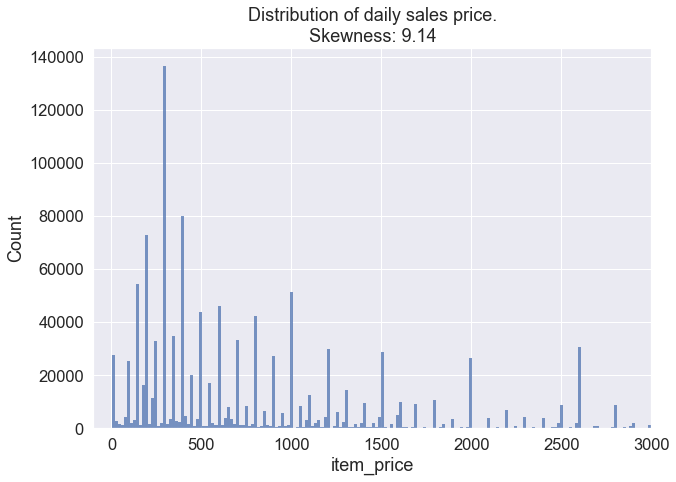

In [130]:
ax = sns.histplot(x=train_df.item_price)
ax.set_title('Distribution of daily sales price.\nSkewness: {}'.format(str(round(stats.skew(train_df.item_price), 2))))
ax.set_xlim(-100,3000.);

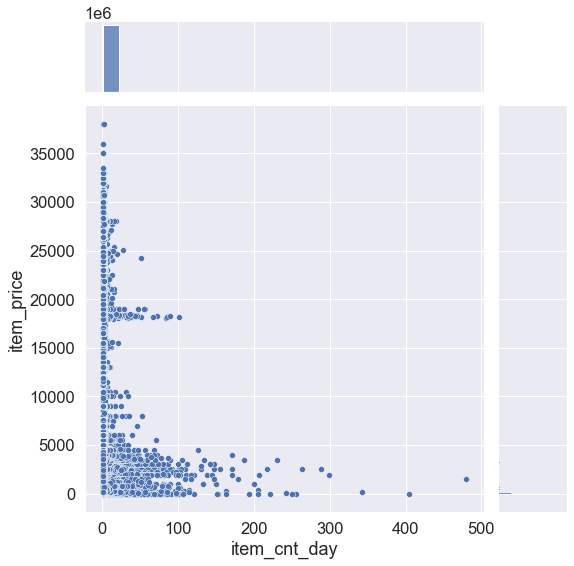

In [135]:
sns.jointplot(x='item_cnt_day', y='item_price', data=train_df[(train_df.item_cnt_day >= 0)
                                                              &(train_df.item_price < 40000)
                                                              &(train_df.item_cnt_day < 500)], 
              height=8);

**On this filtered joint distribution we can see that high prices are mainly connected to 1-5 unit sales, and sales with of large units have lower prices**

Analazying **monthly item price** and **sales count** for each **date block** using line plot.

In [88]:
def trend_line_plot(df, date_col: str, x: str, agg_func: str, name: str, title: str = '', add_corr=False):
    df1 = df.groupby(date_col).agg({x:agg_func})
    df1.columns=[name]
    df1.reset_index(inplace=True)
    
    ax = sns.lineplot(data=df1, x=date_col, y=name) 
    start, end = df1[date_col].min(), df1[date_col].max()
    ax.set_xticks(range(start, end+1, 3))
    if add_corr: ax.set_title(title + 'Correlation: {}'.format(df1.corr()[name][0].round(3)))
    else: ax.set_title(title)
    return ax

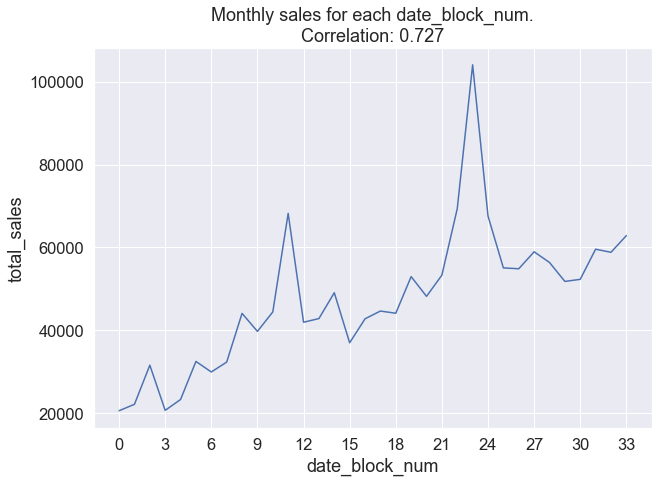

In [140]:
trend_line_plot(train_df, 'date_block_num', 'item_cnt_day', 'sum', 'total_sales', 'Monthly sales for each date_block_num.\n', add_corr=True);

**Most sales were made on December (as it's time of Russian most famous holidays) both in 2013 and 2014, there's an increasing trend of sales. Correlation is pretty high.** Next in feature engineering we could also add month as a feature.

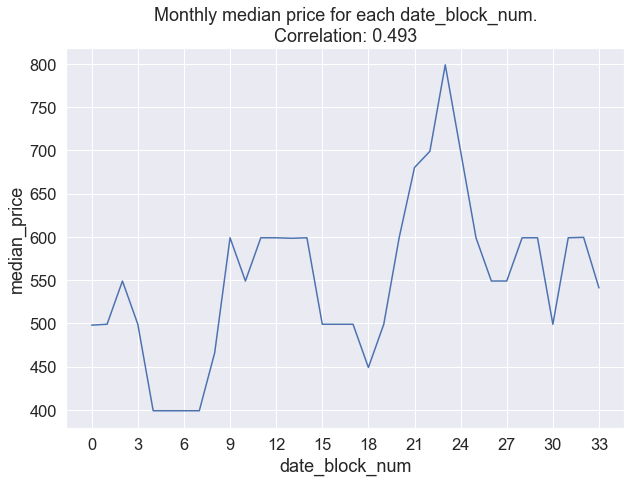

In [141]:
trend_line_plot(train_df, 'date_block_num', 'item_price', 'median', 'median_price', 'Monthly median price for each date_block_num.\n', add_corr=True);

**The highest increase of median price during the year were on the 2nd half of the year, the highest peak is on December 2014 (so people during this month buy more expensive items), there's an increasing trend of median price during this period. Correlation is moderate.** 

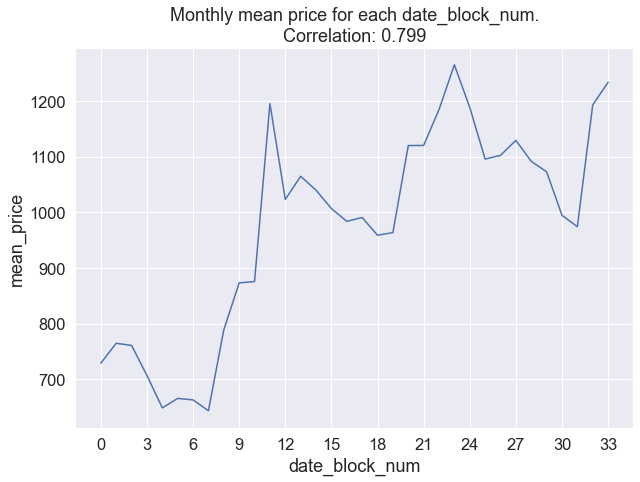

In [165]:
trend_line_plot(train_df, 'date_block_num', 'item_price', 'mean', 'mean_price', 'Monthly mean price for each date_block_num.\n', add_corr=True);

**The peaks of mean price during the year also mainly on December, there's an increasing trend. Correlation is higher than for median prise. Next we'll use mean of item price, when we'll group daily data.**

Let's look at sales by day of week. Unfortunately this variable cannot be used when we'll build model, because we have to predict monthly sales, which have no day of week.

In [142]:
# 0 - Monday, 6 - Sunday
train_df['day_of_week'] = train_df.date.dt.dayofweek

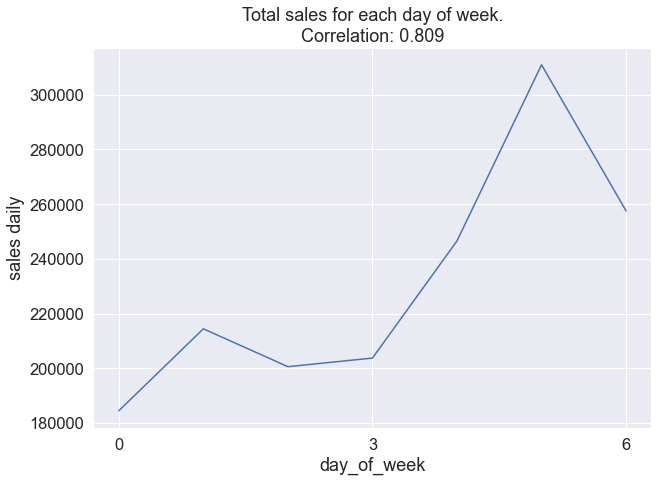

In [143]:
trend_line_plot(train_df, x='item_cnt_day', date_col='day_of_week', name='sales daily', title='Total sales for each day of week.\n', agg_func='sum', add_corr=True);

In [144]:
train_df.drop('day_of_week', axis=1, inplace=True)

**Most sales were made on Saturday. Correlation is pretty high**

### By far we've examined amount of sales and its prices: 
- both variables have skewed distribution, which means that we should delete outliers
- December is the most profitable and demanded montn (during this month people buy more expensive items rather than cheaper)
- The amount of sales and mean item price during each year and month has an increasing trend, especially during the 2nd half of the year. Both variables have a good correlation with date block variable
- Also sales are made mainly during weekends<br>
#### Now we'll dive into shops and items and grab info from these dfs.

In [41]:
def make_bar_plot(df, x: str, top_n: int, y_label: str, title: str, w_group=False, group_var=None, agg_func=None):
    # if want to group by a specified feature
    if w_group:
        df = df.groupby(group_var).agg({x:agg_func})
        df.columns = [y_label]
        df.sort_values(by=y_label, inplace=True, ascending=False)
        
    # if want see the head categories
    if top_n > 0:
        if w_group:
            categories = df[:top_n].index
            top_vals = df[:top_n][y_label]
        else:
            categories = df[x].value_counts()[:top_n].index
            top_vals = df[x].value_counts()[:top_n]
    # if the tail
    else:
        if w_group:
            categories = df[top_n:].index
            top_vals = df[top_n:][y_label]
        else:
            categories = df[x].value_counts()[top_n:].index
            top_vals = df[x].value_counts()[top_n:] 
        
    ax = sns.barplot(x=categories, y=top_vals)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set(ylabel=y_label)
    ax.set_title(title)
    return ax

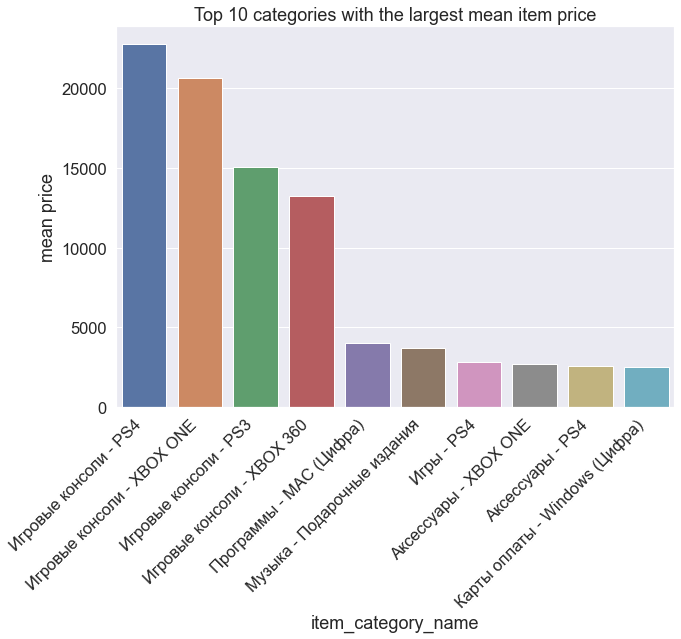

In [234]:
make_bar_plot(train_df, x='item_price', top_n=10, y_label='mean price', title='Top 10 categories with the largest mean item price', w_group=True, group_var='item_category_name', agg_func='mean');

**The most expensive categories are game consoles, music, games**

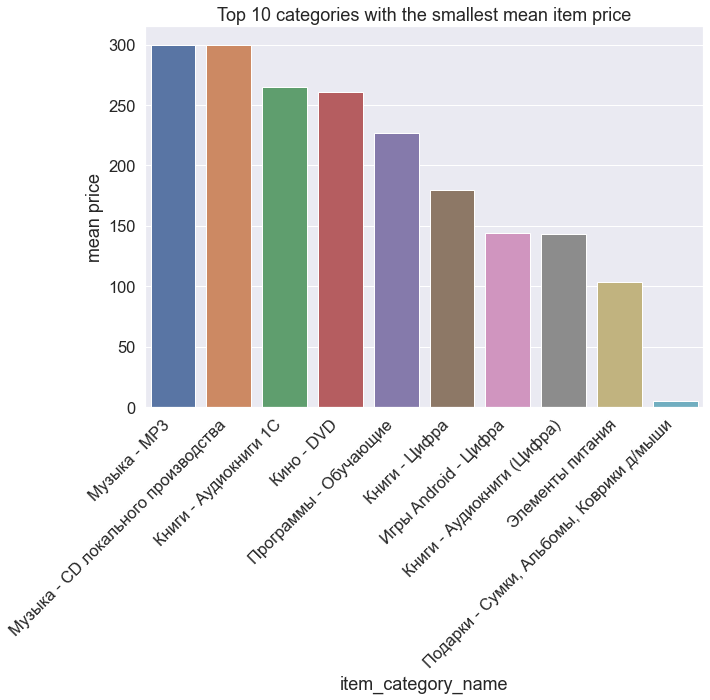

In [235]:
make_bar_plot(train_df, x='item_price', top_n=-10, y_label='mean price', title='Top 10 categories with the smallest mean item price', w_group=True, group_var='item_category_name', agg_func='mean');

**The least expensive are books, food, movies and music**. We have music category both in the most/least expensive items, so it will be also good to pay attention to subcategory.

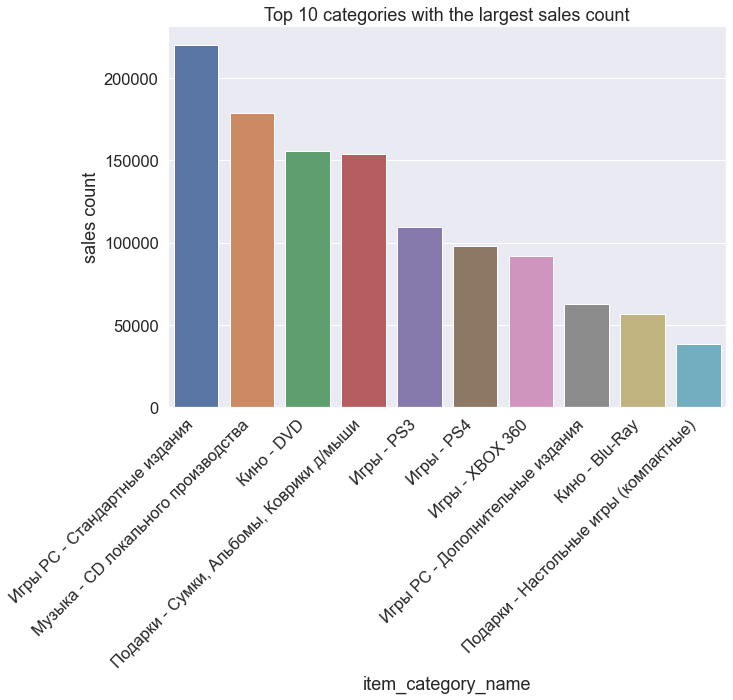

In [236]:
make_bar_plot(train_df, x='item_cnt_day', top_n=10, y_label='sales count', title='Top 10 categories with the largest sales count', w_group=True, group_var='item_category_name', agg_func='sum');

**The most popular categories within train df are connected with games and movies**. Also some of most popular items are among items with the lowest prices (i.e. Музыка CD, Подарки, Кино DVD)

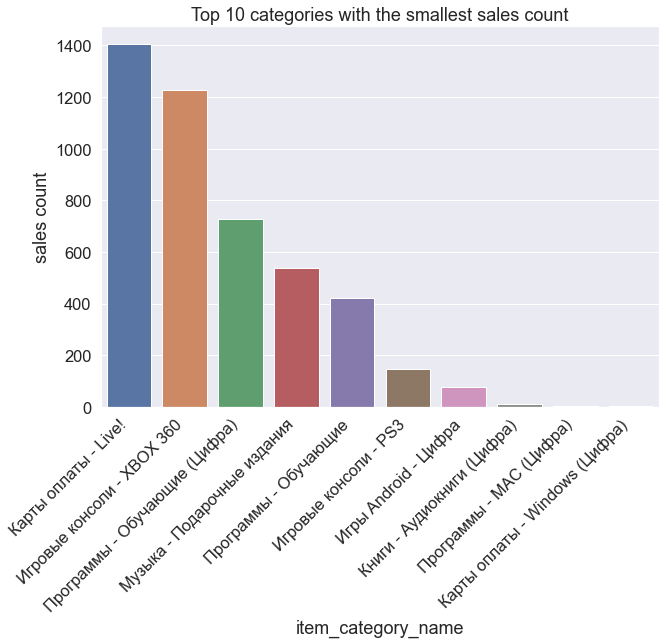

In [237]:
make_bar_plot(train_df, x='item_cnt_day', top_n=-10, y_label='sales count', title='Top 10 categories with the smallest sales count', w_group=True, group_var='item_category_name', agg_func='sum');

**The least popular categories within train df are connected with programms, books**<br>
By far we can observe that most popular items have the lowest prices, different categories affect item sales and prices.

**There are about 4700 of unique item names in df**

In [238]:
train_df.item_name.nunique()

4716

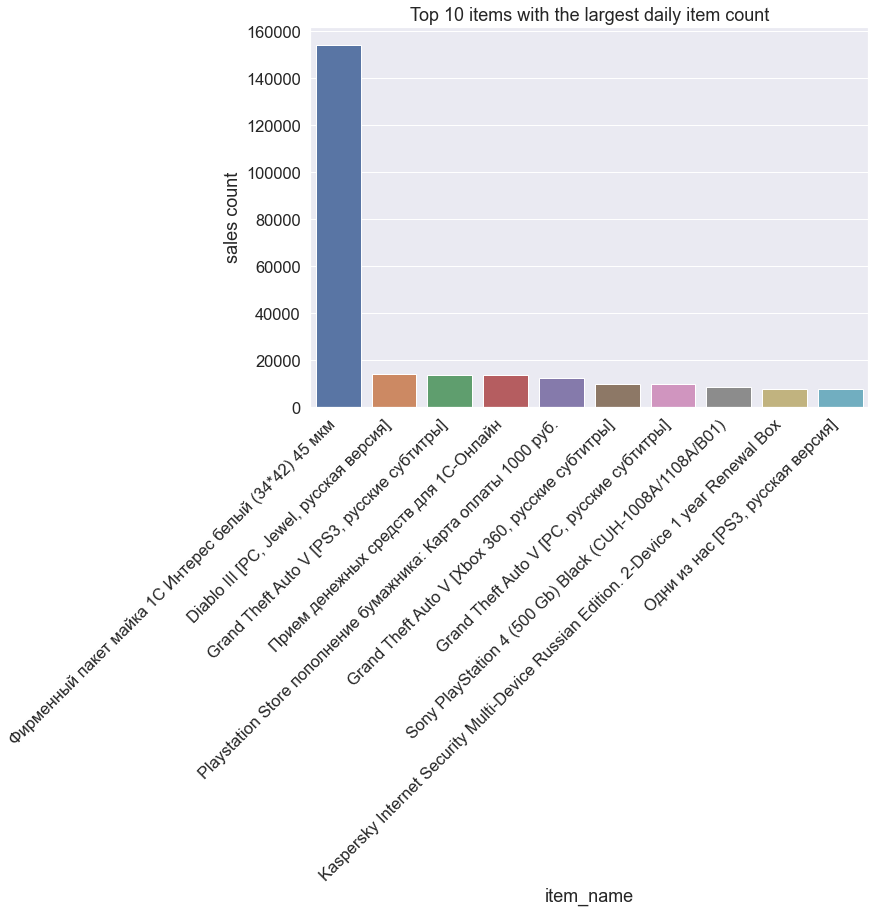

In [239]:
make_bar_plot(train_df, x='item_cnt_day', top_n=10, y_label='sales count', title='Top 10 items with the largest daily item count', w_group=True, group_var='item_name', agg_func='sum');

Top sold item is a packet, then goes mainly game consoles and games

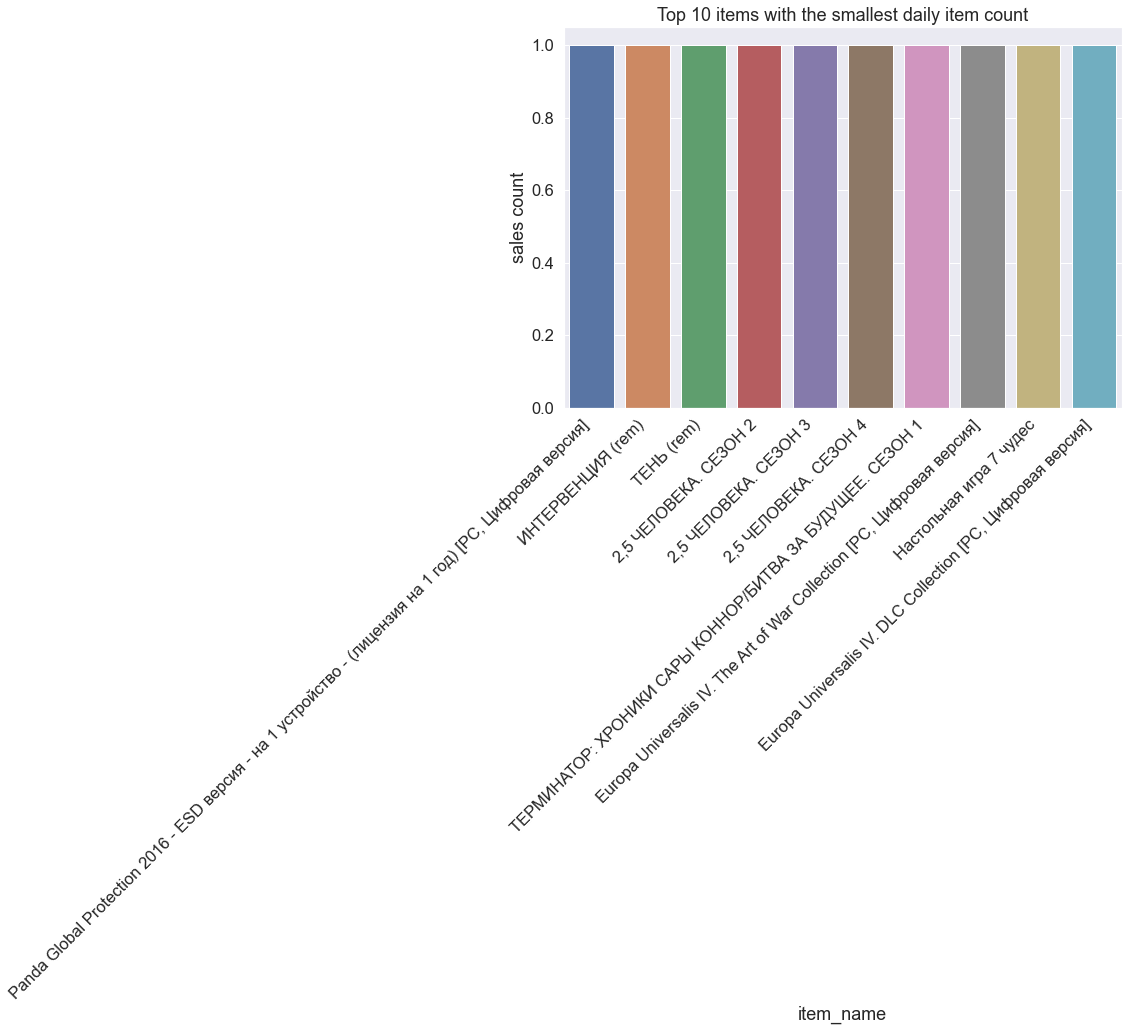

In [240]:
make_bar_plot(train_df, x='item_cnt_day', top_n=-10, y_label='sales count', title='Top 10 items with the smallest daily item count', w_group=True, group_var='item_name', agg_func='sum');

**It's difficult to differentiate sales by item name (there are many unique and long item names, so it's complicated to extract anything from it which will be suitable for all items of the same category)**. So we won't use this feature.

Add feature like **revenue**, which is combination of sales amount and its prices. 

In [241]:
train_df['revenue'] = train_df.item_cnt_day * train_df.item_price

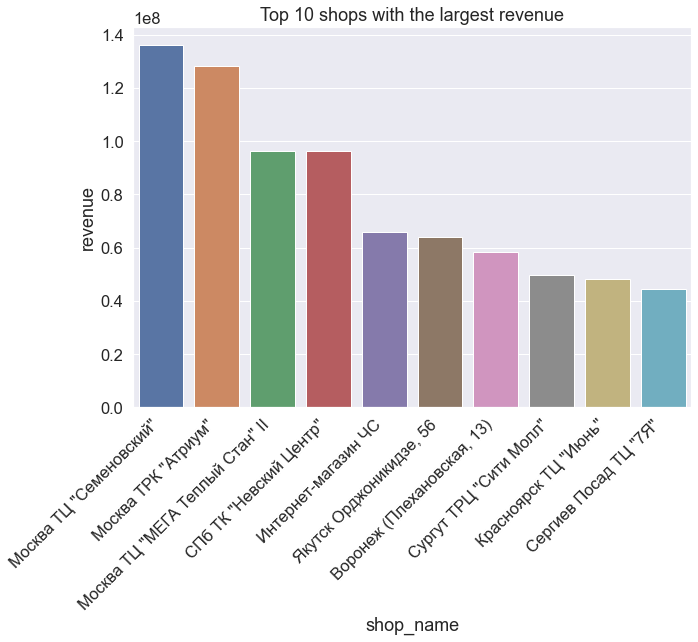

In [244]:
ax=make_bar_plot(train_df, 'revenue', top_n=10, y_label='revenue',title='Top 10 shops with the largest revenue', w_group=True, group_var='shop_name', agg_func='sum');
# the largest revenue - 246,977,870.00250226

**The most profitable shops come from large cities such as Moscow, St.Petersburg**

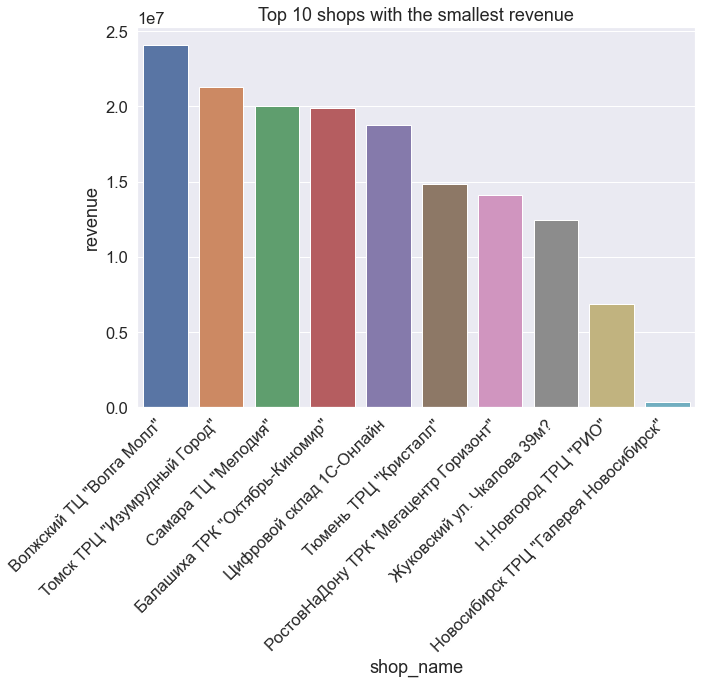

In [246]:
make_bar_plot(train_df, 'revenue', top_n=-10, y_label='revenue',title='Top 10 shops with the smallest revenue', w_group=True, group_var='shop_name', agg_func='sum');

**The least profitable shops come smaller and poorer cities than Moscow**. So it's possible to extract city name from shop name and encode it, which we'll do in Feature engineering section.

## Grouped data

In [6]:
df = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean']})

df.columns = ['item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt']
df.reset_index(inplace=True)

In [7]:
df.head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt
0,0,2,33,499.0,499.0,1.0,1.0
1,0,2,482,3300.0,3300.0,1.0,1.0
2,0,2,491,600.0,600.0,1.0,1.0
3,0,2,839,3300.0,3300.0,1.0,1.0
4,0,2,1007,1347.0,449.0,3.0,1.0


**Build df with all the possible combinations of ['date_block_num','shop_id','item_id'] to have no problems when we'll make lag vars and ensure that we have combinations that can be in test data**

In [8]:
shop_ids = df['shop_id'].unique()
item_ids = df['item_id'].unique()

empty_df = list(product(range(34), shop_ids, item_ids))  
empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])

In [9]:
empty_df.tail()

,date_block_num,shop_id,item_id
6734443,33,36,9103
6734444,33,36,9107
6734445,33,36,10204
6734446,33,36,12733
6734447,33,36,15925


In [10]:
# merge the train set with the complete set (missing records filled with 0s).
df = pd.merge(empty_df, df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df.fillna(0, inplace=True)

In [11]:
df.shape 
# almost 7 billion!

(6734448, 7)

In [12]:
df.loc[:,['item_price', 'item_cnt']][df.item_price > 0].describe().round(2)
# we have many 0s in df because of missing values
# so let's look only at those, where price > 0

,item_price,item_cnt
count,600439.00,600439.00
mean,2102.46,2.70
std,7011.99,11.29
min,0.50,-4.00
25%,299.00,1.00
50%,747.00,1.00
75%,1849.00,2.00
max,515573.59,2253.00


In [13]:
df.item_cnt.quantile(0.99)

4.0

## Simple baseline
For a baseline I've chosen **naive seasonal method** (i.e. a forecast for February 2014 is based on Fabruary 2013), remember that our sales count has an increasing trend with a seasonal pattern: sales are getting higher in the 2nd half of the year, closer to winter holidays, while decreasing during January-July months.

In [14]:
df['naive_preds'] = df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(12)
df[df.naive_preds >= 0].head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,naive_preds
2376864,12,2,33,199.0,199.0,1.0,1.0,1.0
2376865,12,2,482,6600.0,3300.0,2.0,1.0,1.0
2376866,12,2,491,0.0,0.0,0.0,0.0,1.0
2376867,12,2,839,3300.0,3300.0,1.0,1.0,1.0
2376868,12,2,1007,599.0,599.0,1.0,1.0,3.0


In [15]:
# check: from the previous table, for January 2014, shop 2 and item 1007 prediction == 3
# item_cnt == 3 for January 2013, shop 2 and item 1007
df[(df.shop_id==2)&(df.item_id==1007)][:1]

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,naive_preds
4,0,2,1007,1347.0,449.0,3.0,1.0,NaN


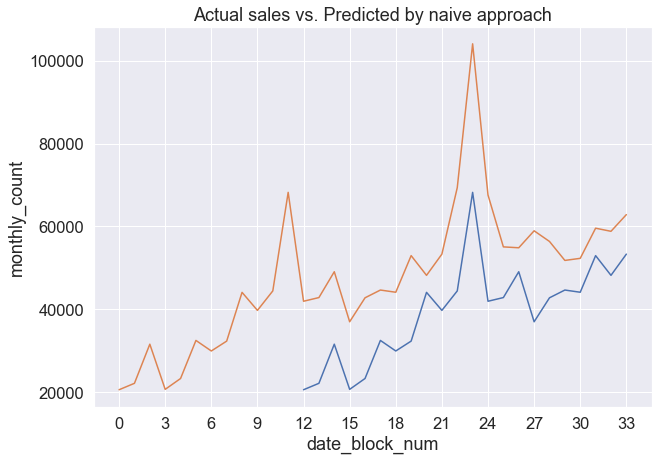

In [174]:
ax = trend_line_plot(df=df[df.date_block_num > 11], date_col='date_block_num', x='naive_preds', name='monthly_count', agg_func='sum')
ax = trend_line_plot(df=df, date_col='date_block_num', x='item_cnt', name='monthly_count', agg_func='sum', title='Actual sales vs. Predicted by naive approach')

## Cross-validation strategy
Our goal is to predict sales for next month (November 2015 or 34 date_block_num):
- For train data we'll use range of [3, 27] date_blocks (as we'll create lagged features (with the highest lag=3), so in the first 3 blocks there will be a lot missing values), for validation set - [28,32] date_blocks and test set - 33 date_block_num
- For naive seasonal approach we will simply make split and evaluate metric
- For a future model, we'll create a variable **item_cnt_month**, which will represent one backward shift of **item_cnt** for a given pair of shop and item id and will be our target in prediction.<br>Date_block_num 33 (our last date block) will have nan values for target, as it's expected.

In data we have item_cnt == -1, so when calculating RMSLE there will be problems (i.e. undefined log(0)). So I've decided to handle outliers and then evaluate predictions made by naive approach.<br>When we'll make test split (date_block_num 33) from our main data, we'll merge it (right join) with test data (in order to have all pairs of shop and item that are in test data which can be missed after removing outliers).

### Explore outliers

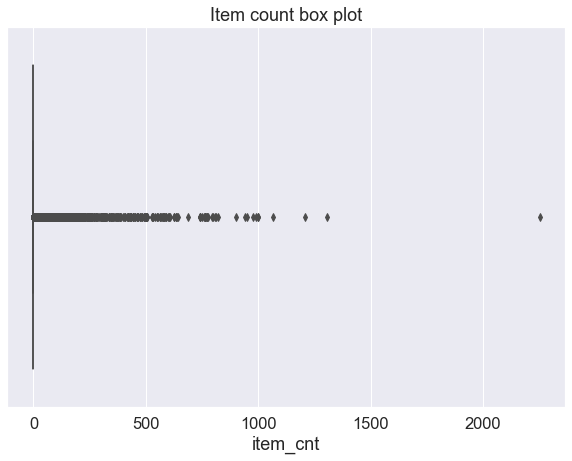

In [175]:
ax = sns.boxplot(data=df, x='item_cnt');
ax.set_title('Item count box plot');

**On this plot we see outliers, but it's hard to determine wich range to use, because test data says that range should be [0, 20], so we'll also use this range**

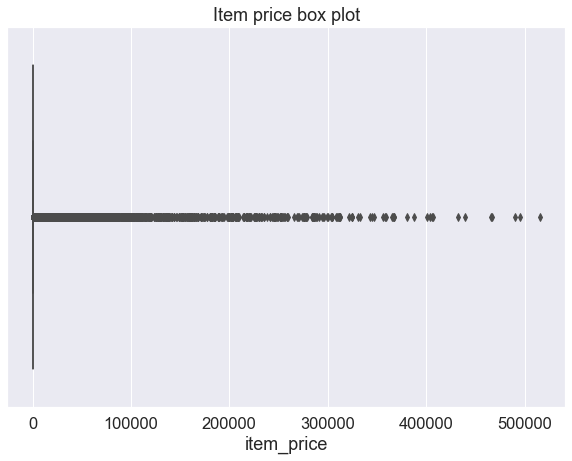

In [176]:
ax = sns.boxplot(data=df, x='item_price');
ax.set_title('Item price box plot');

**On this boxplot we can clearly see outliers for prices, probably better range would be [0, 300000]**

In [130]:
df.shape

(6734448, 8)

In [16]:
# remove outliers for item cnt and item price
df = df.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 300000')
# we lost about 6,000 observations
df.shape

(6728106, 8)

### Evaluating baseline (will be changed)

In [18]:
df['naive_preds'] = np.clip(df.naive_preds, 0, 20)

In [20]:
y_train = df[(df.date_block_num > 11) & (df.date_block_num < 28)].item_cnt.values
y_val = df[(df.date_block_num > 27) & (df.date_block_num < 33)].item_cnt.values

preds_train = df[(df.date_block_num > 11) & (df.date_block_num < 28)].naive_preds.values
preds_val = df[(df.date_block_num > 27) & (df.date_block_num < 33)].naive_preds.values

naive_train = root_mean_sqr_log_error(y_train, preds_train)
naive_val = root_mean_sqr_log_error(y_val, preds_val)

In [21]:
print('RMSLE for train data: {}\nRMSLE for val data: {}'.format(round(naive_train, 3), round(naive_val,3)))

RMSLE for train data: 0.365
RMSLE for val data: 0.415


In [22]:
df.drop('naive_preds', axis=1, inplace=True)

**So with baseline approach RMSLE for train data is 0.36 and for validation data is 0.41**<br>
### Now let's add target variable to our main df.

In [23]:
df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)[:5]
# let's check value (in our case - 6) for observation with index 132060

0         0.0
132060    6.0
132061    4.0
132062    1.0
132063    4.0
Name: item_cnt, dtype: float64

In [146]:
df[(df.shop_id==50)&(df.item_id==1523)][:3]
# backward shift worked

,date_block_num,shop_id,item_id,item_price,median_item_price,item_cnt,median_item_cnt
132060,0,50,1523,5593.0,799.0,8.0,1.0
330132,1,50,1523,3995.0,799.0,6.0,1.0
528204,2,50,1523,2396.7,799.0,3.0,1.0


In [24]:
df['item_cnt_month'] = df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [148]:
# example
df[(df.shop_id==50)&(df.item_id==1523)]

,date_block_num,shop_id,item_id,item_price,median_item_price,item_cnt,median_item_cnt,item_cnt_month
132060,0,50,1523,5593.00,799.000,8.0,1.0,6.0
330132,1,50,1523,3995.00,799.000,6.0,1.0,3.0
528204,2,50,1523,2396.70,799.000,3.0,1.0,2.0
726276,3,50,1523,799.00,799.000,2.0,2.0,1.0
924348,4,50,1523,798.70,798.700,1.0,1.0,3.0
1122420,5,50,1523,1598.00,799.000,3.0,1.5,3.0
1320492,6,50,1523,2397.00,799.000,3.0,1.0,5.0
1518564,7,50,1523,3196.00,799.000,5.0,1.0,1.0
1716636,8,50,1523,799.00,799.000,1.0,1.0,2.0
1914708,9,50,1523,1598.00,799.000,2.0,1.0,2.0


In [25]:
df.isna().sum()

date_block_num          0
shop_id                 0
item_id                 0
item_price              0
mean_item_price         0
item_cnt                0
mean_item_cnt           0
item_cnt_month     198071
dtype: int64

In our new target we have missing values because of 1) for date_block_num 33 there are only nans; 2) we removed outliers

## Feature engineering

**Time features**

In [26]:
df['year'] = df['date_block_num'].apply(lambda x: ((x//12) + 2013))
df['month'] = df['date_block_num'].apply(lambda x: (x % 12))
# 0 - 1st, 1 - 2nd
df['half_of_year'] = 0
ids = df[df.date_block_num.isin([6 + 12*i + j for i in range(3) for j in range(6)][:-2])].index
df.loc[ids, 'half_of_year'] = 1
del ids

**Unitary item prices**

In [27]:
df['item_price_unit'] = df['item_price'] // df['item_cnt']
# as we have 0s in item_cnt we'll have nan in new created variable
df['item_price_unit'].fillna(0, inplace=True)

**Group based features**

**Rolling window based features**

**Laged features**

**Trend features**

**Text encoded features**

In [109]:
train_df['city'] = train_df.shop_name.str.split(' ').map(lambda x: x[0])
train_df.loc[train_df.city == '!Якутск', 'city'] = 'Якутск'

split = train_df.item_category_name.str.split('-')
train_df['type'] = split.map(lambda x: x[0].strip())
train_df['subtype'] = split.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

Prepared data

In [29]:
#train_df.to_csv('train_demo1.csv', index=False)
df.to_csv('df_demo1.csv', index=False)

In [28]:
df.head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,item_cnt_month,year,month,half_of_year,item_price_unit
0,0,2,33,499.0,499.0,1.0,1.0,0.0,2013,0,0,499.0
1,0,2,482,3300.0,3300.0,1.0,1.0,1.0,2013,0,0,3300.0
2,0,2,491,600.0,600.0,1.0,1.0,0.0,2013,0,0,600.0
3,0,2,839,3300.0,3300.0,1.0,1.0,1.0,2013,0,0,3300.0
4,0,2,1007,1347.0,449.0,3.0,1.0,1.0,2013,0,0,449.0
